In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    #plot_confusion_matrix,
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [4]:
# Read in training data
df = pd.read_csv("train.csv")

In [5]:
train_data = df.copy()

In [6]:
# Look at subset of data
train_data.sample(n=10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
461,462,0,3,"Morley, Mr. William",male,34.0,0,0,364506,8.0500,NaN,S
841,842,0,2,"Mudd, Mr. Thomas Charles",male,16.0,0,0,S.O./P.P. 3,10.5000,NaN,S
456,457,0,1,"Millet, Mr. Francis Davis",male,65.0,0,0,13509,26.5500,E38,S
594,595,0,2,"Chapman, Mr. John Henry",male,37.0,1,0,SC/AH 29037,26.0000,NaN,S
436,437,0,3,"Ford, Miss. Doolina Margaret ""Daisy""",female,21.0,2,2,W./C. 6608,34.3750,NaN,S
360,361,0,3,"Skoog, Mr. Wilhelm",male,40.0,1,4,347088,27.9000,NaN,S
658,659,0,2,"Eitemiller, Mr. George Floyd",male,23.0,0,0,29751,13.0000,NaN,S
174,175,0,1,"Smith, Mr. James Clinch",male,56.0,0,0,17764,30.6958,A7,C
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
659,660,0,1,"Newell, Mr. Arthur Webster",male,58.0,0,2,35273,113.2750,D48,C


In [7]:
# Number of rows and columns
train_data.shape

(891, 12)

In [8]:
# Information on each column
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
# Statistical description
train_data.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891.0,NaN,NaN,NaN,446.0,257.353842,1.0,223.5,446.0,668.5,891.0
Survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
Name,891,891,"Braund, Mr. Owen Harris",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714.0,NaN,NaN,NaN,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
SibSp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
Parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
Ticket,891,681,347082,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292


In [10]:
# Missing values for each column
train_data.isnull().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

#### Observations
- Passenger ID is not required for prediction as it is not expected to be correlated to survival.
- Most of the Cabin values are null, and this feature is not expected to contribute to prediction. Feature column will be dropped.
- Name column is not expected to have any significant correlation with survival, and will be dropped.
- Ticket number is a combination of string and numeric data. It will be split into two columns, one containing the string portion, and the other containing the numeric portion.
- There are some missing values in Age and Embarked features, which will need treatment.

In [13]:
# Split Ticket into a string and corresponding numeric column
train_data[['Ticket_string', 'Ticket_num']] = train_data['Ticket'].str.extract(r'(.*?)(\d+)$')
train_data['Ticket_num'] = pd.to_numeric(train_data['Ticket_num'], errors='coerce')  # Coerce any non-numeric to NaN

In [19]:
# Check data with missing Ticket number values
train_data[train_data["Ticket_num"].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_string,Ticket_num
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S,NaN,NaN
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S,NaN,NaN
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S,NaN,NaN
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S,NaN,NaN


(array([580., 263.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  44.]),
 array([3.0000000e+00, 3.1013440e+05, 6.2026580e+05, 9.3039720e+05,
        1.2405286e+06, 1.5506600e+06, 1.8607914e+06, 2.1709228e+06,
        2.4810542e+06, 2.7911856e+06, 3.1013170e+06]),
 <BarContainer object of 10 artists>)

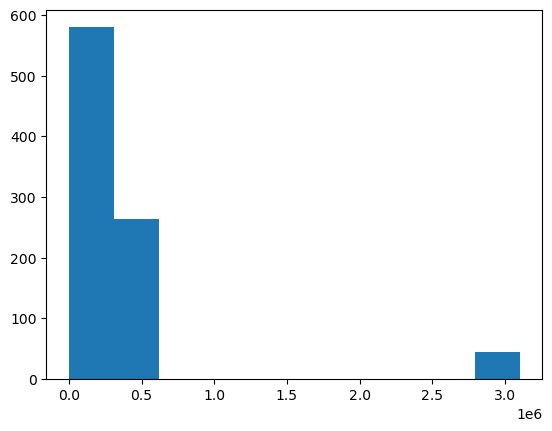

In [23]:
# Check for distribution of the numeric part of ticket
plt.hist(train_data["Ticket_num"])

In [25]:
# Drop irrelevant columns
train_data.drop(["PassengerId","Name","Ticket","Cabin","Ticket_string"],axis=1,inplace=True)

In [26]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Ticket_num
0,0,3,male,22.0,1,0,7.2500,S,21171.0
1,1,1,female,38.0,1,0,71.2833,C,17599.0
2,1,3,female,26.0,0,0,7.9250,S,3101282.0
3,1,1,female,35.0,1,0,53.1000,S,113803.0
4,0,3,male,35.0,0,0,8.0500,S,373450.0


In [27]:
# Check for class distribution
round(train_data["Survived"].value_counts(normalize=True)*100,2)

Survived
0    61.62
1    38.38
Name: proportion, dtype: float64

_Class is somewhat imbalanced._

In [33]:
# Define numeric variables
num_vars = ["Age","Fare","Parch","SibSp","Ticket_num"]

In [35]:
#Define categorical variables
cat_vars = ["Sex","Pclass","Embarked"]

In [37]:
# Look at statistical data for numerical variables
train_data[num_vars].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,8.000000e+01
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,5.123292e+02
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.000000e+00
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.000000e+00
Ticket_num,887.0,298328.417136,657614.377640,3.00,14879.0000,112277.0000,347082.0,3.101317e+06


In [39]:
# Check for unique values for categorical variables
for var in cat_vars:
    print(f"{var}:",train_data[var].unique())

Sex: ['male' 'female']
Pclass: [3 1 2]
Embarked: ['S' 'C' 'Q' nan]


### Exploratory Data Analysis

#### Univariate Analysis

##### Continuous Variables

In [44]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

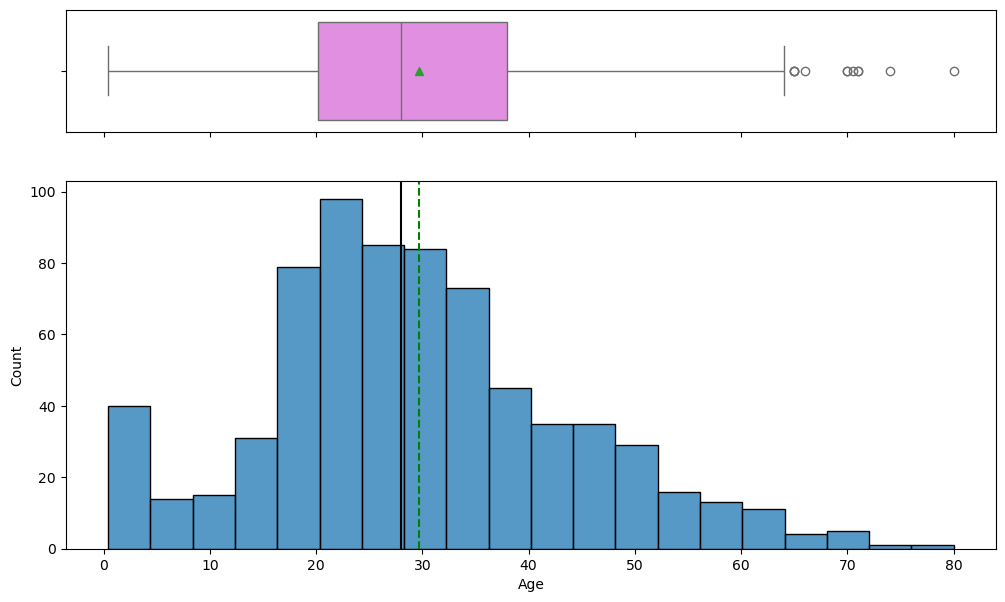

In [46]:
# Observations on Passenger age
histogram_boxplot(train_data,"Age")

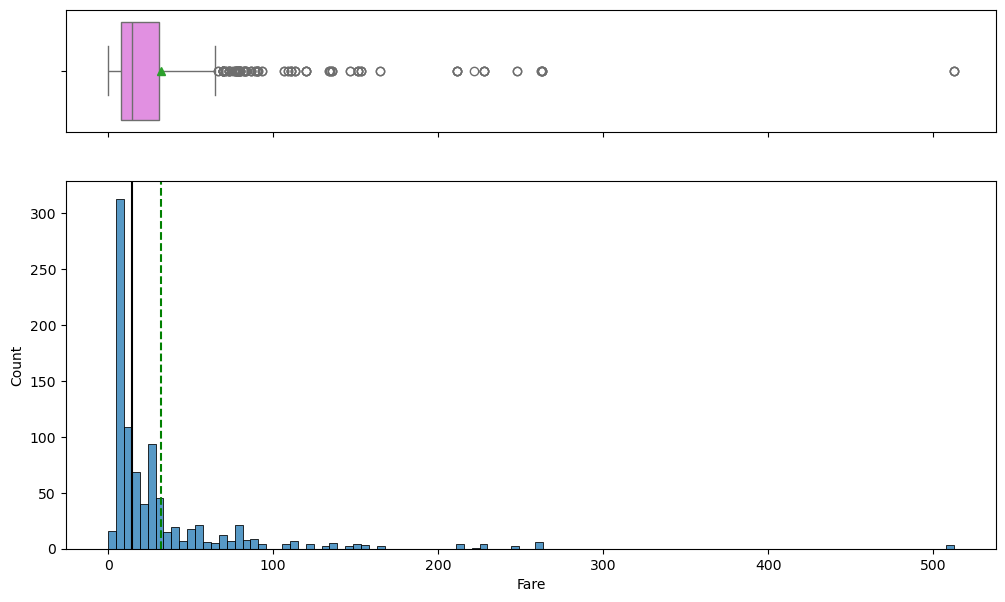

In [47]:
# Observations on Passenger's ticket Fare
histogram_boxplot(train_data,"Fare")

In [48]:
# Check rows with fare > 300
train_data[train_data["Fare"] > 300]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Ticket_num
258,1,1,female,35.0,0,0,512.3292,C,17755.0
679,1,1,male,36.0,0,1,512.3292,C,17755.0
737,1,1,male,35.0,0,0,512.3292,C,17755.0


_These will not be considered as outliers_

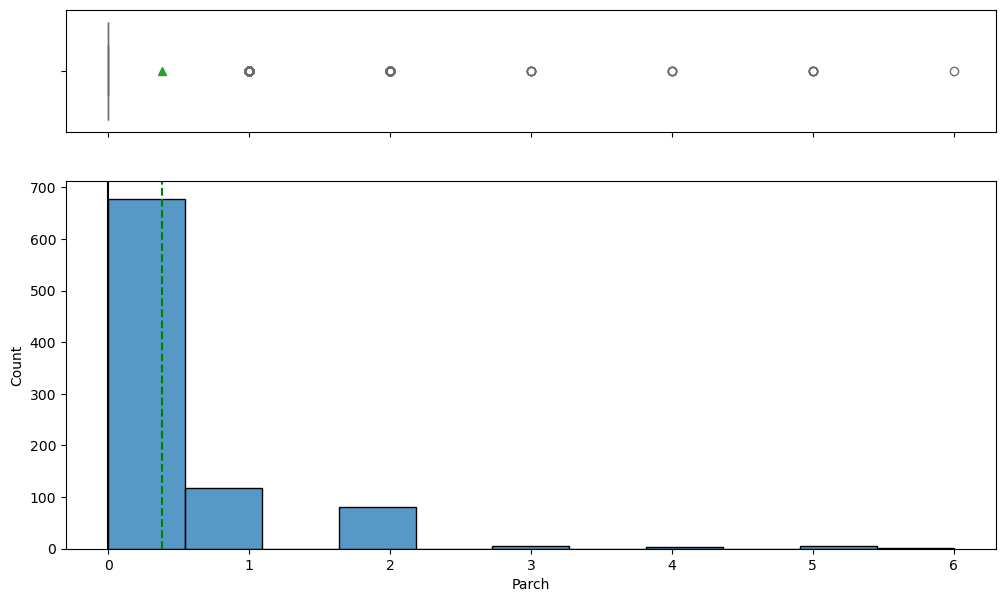

In [53]:
# Observations on number of parents/children accompanying the passengers
histogram_boxplot(train_data,"Parch")

_Most passengers did not have parents or children accompanying them_

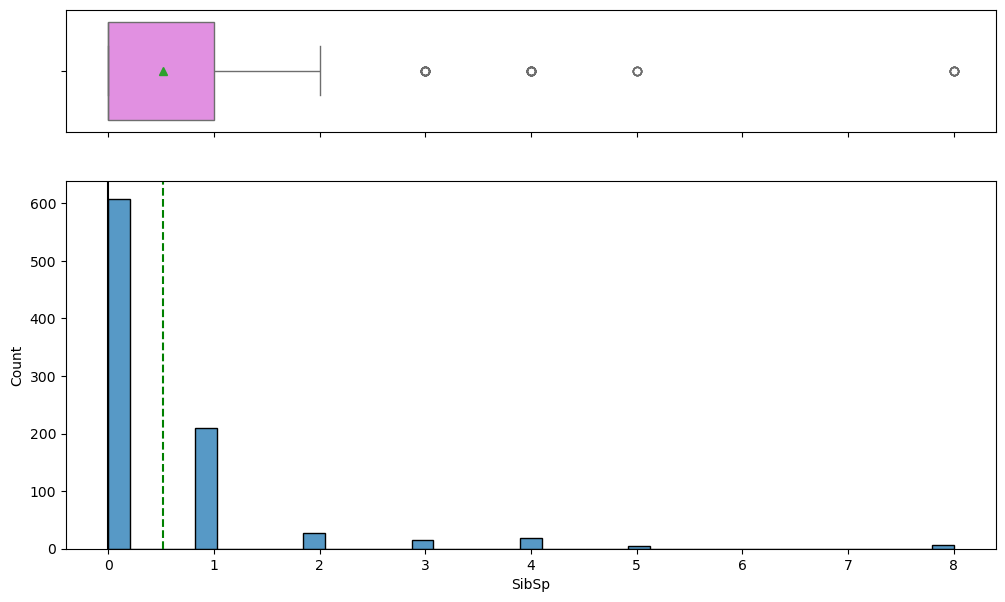

In [55]:
# Observations on number of siblings/spouses accompanying the passengers
histogram_boxplot(train_data,"SibSp")

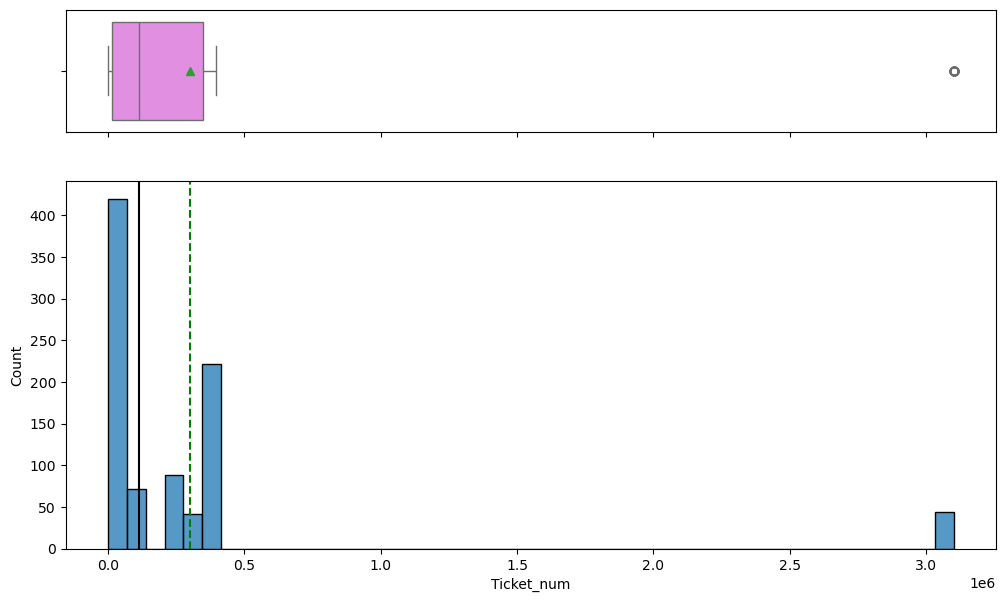

In [57]:
# Observations on numeric portion of the ticket number
histogram_boxplot(train_data,"Ticket_num")

_There is not clear type of distribution in the numeric portion of the ticket number, but we will later look for any relation to the survival variable_

##### Categorical Variables

In [61]:
# function to create labeled barplots

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        hue=feature,
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage


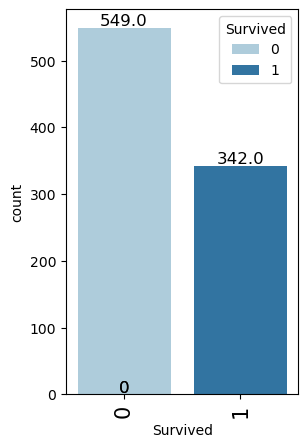

In [62]:
# observations on Survival Status
labeled_barplot(train_data, "Survived")

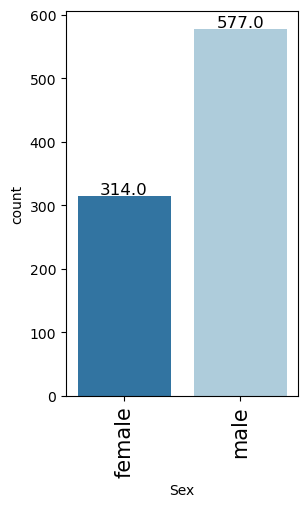

In [65]:
# observations on Passenger Sex
labeled_barplot(train_data, "Sex")

_The ship had many more male passengers than female._

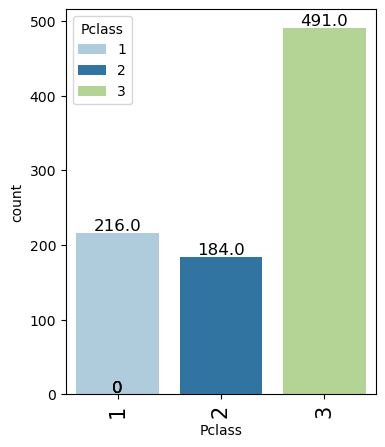

In [68]:
# observations on Passenger Class
labeled_barplot(train_data, "Pclass")

_Most passengers were travelling class 3. In comparison, there were roughly similar number of passengers in class 1 and 2._

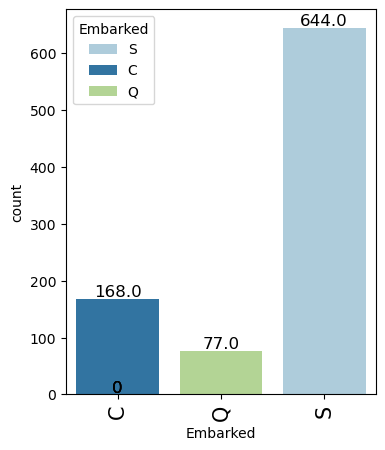

In [71]:
# observations on Passenger Port of Embarkation
labeled_barplot(train_data, "Embarked")

_Most passengers emabarked at Port S._

#### Bivariate Analysis

<Axes: xlabel='Sex', ylabel='Age'>

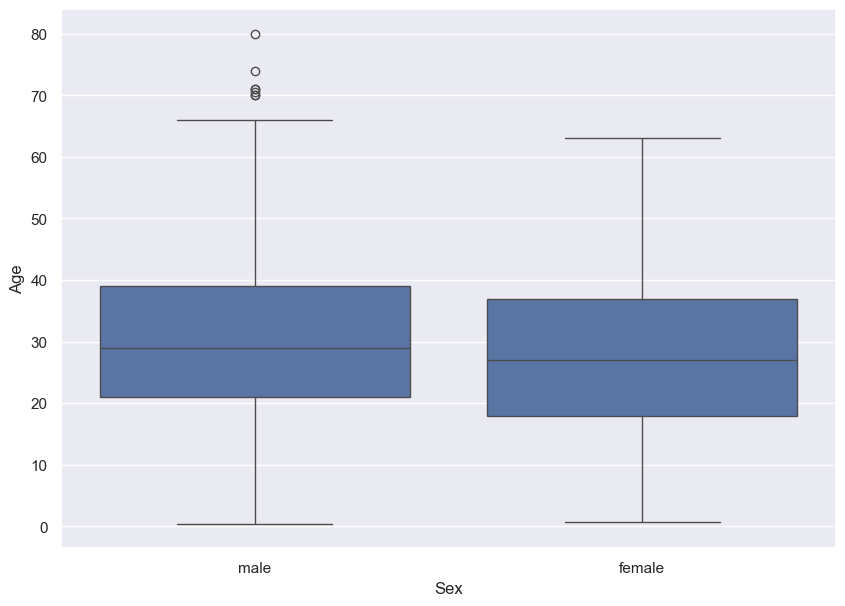

In [75]:
# Plotting Age v/s sex
sns.set(rc={"figure.figsize": (10, 7)})
sns.boxplot(y="Age", x="Sex", data=train_data, orient="vertical")

_Male passengers median age was slightly higher than female passengers, and the oldest passengers were predominantly male._

<Axes: xlabel='Sex', ylabel='Fare'>

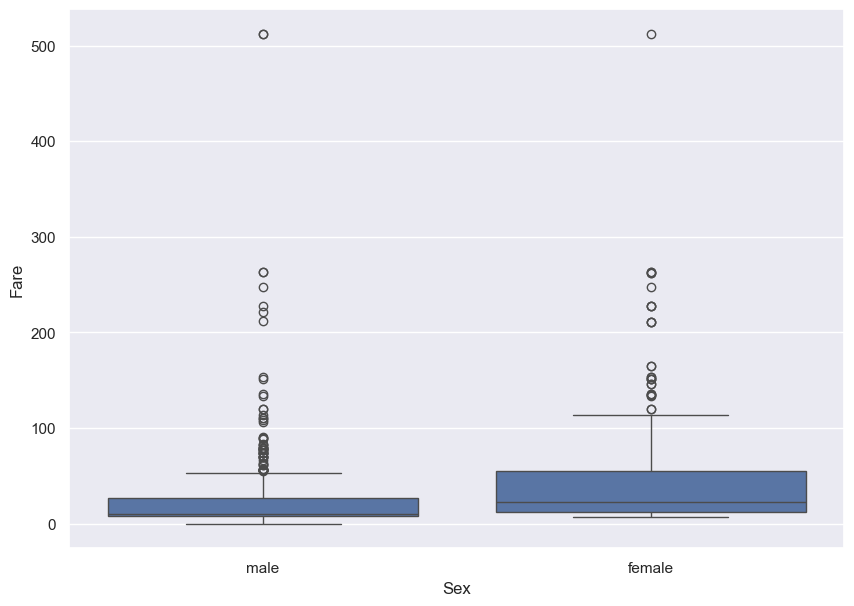

In [78]:
# Plotting Fare v/s Sex
sns.set(rc={"figure.figsize": (10, 7)})
sns.boxplot(y="Fare", x="Sex", data=train_data, orient="vertical")

_Median fare paid by passengers seems to have been higher for females._

##### Numeric variables against target variable (Survived)

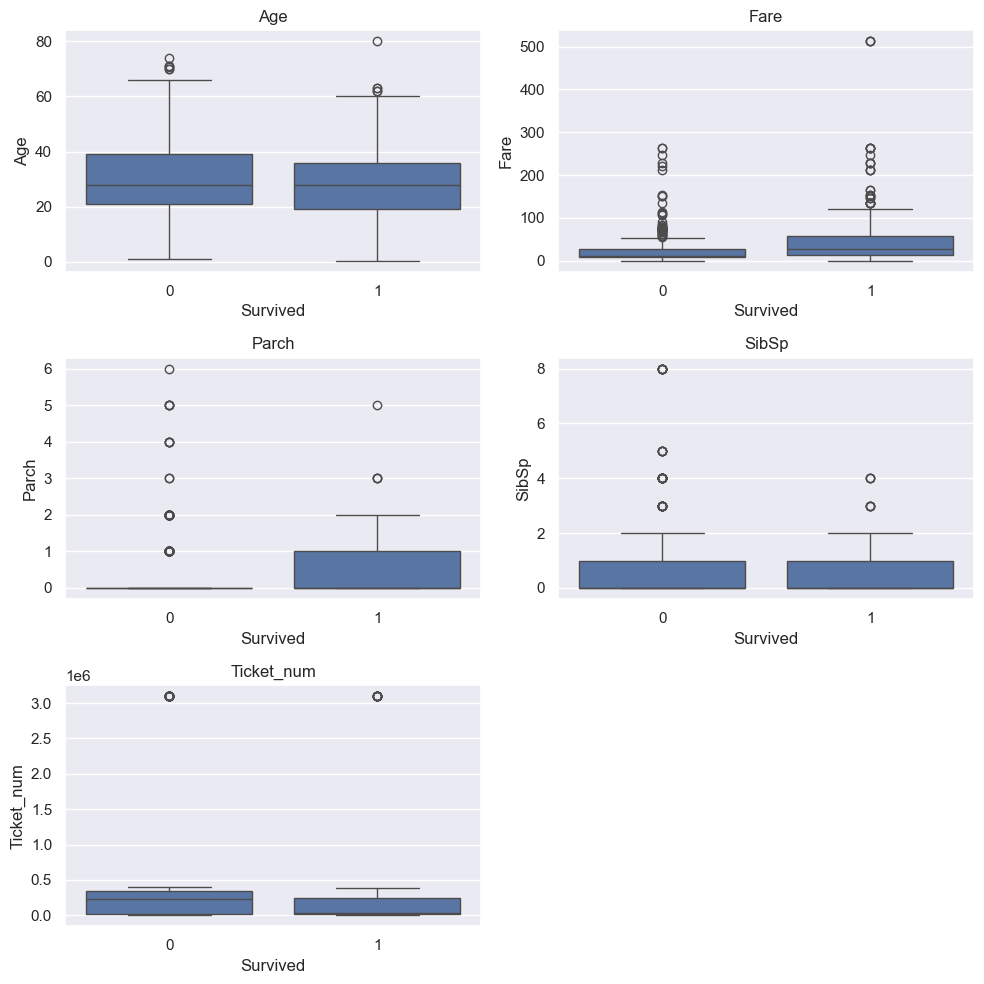

In [83]:
plt.figure(figsize=(10, 10))
for i,col in enumerate(num_vars):
    plt.subplot(3,2,i+1)
    sns.boxplot(x="Survived",y=col,data=train_data)
    plt.tight_layout()
    plt.title(col)
plt.show()

- Passengers who survived paid higher fair on an average than those who didn't.
- Median age of passengers who survived is slightly lesser than those who didn't.
- Surviving passengers had more parents/children accompanying them.
- There seems to be some relation with ticket number. 

##### Categorical variables against target variable

In [86]:
# function to plot stacked bar chart


def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left",
        frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

Survived    0    1  All
Sex                    
All       549  342  891
female     81  233  314
male      468  109  577
------------------------------------------------------------------------------------------------------------------------


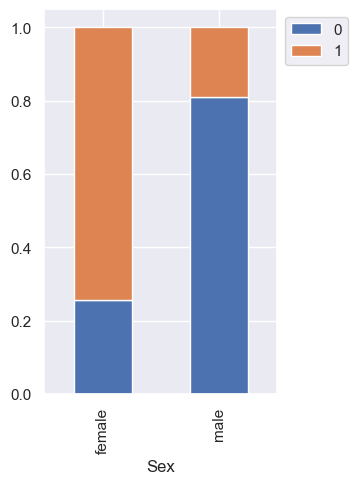

In [87]:
# Plotting output variable against Sex
stacked_barplot(train_data,"Sex","Survived")

_A majority of female passengers survived, while a majority of male passengers did not survive._

Survived    0    1  All
Embarked               
All       549  340  889
S         427  217  644
C          75   93  168
Q          47   30   77
------------------------------------------------------------------------------------------------------------------------


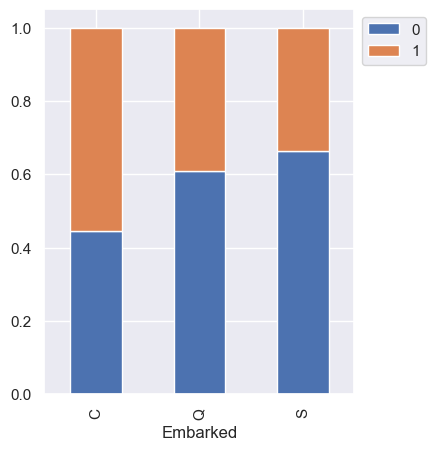

In [89]:
# Plotting output variable against Embarked
stacked_barplot(train_data,"Embarked","Survived")

_A higher percentage of passengers embarking on Port C survived, compared to that of other ports._

Survived    0    1  All
Pclass                 
All       549  342  891
1          80  136  216
3         372  119  491
2          97   87  184
------------------------------------------------------------------------------------------------------------------------


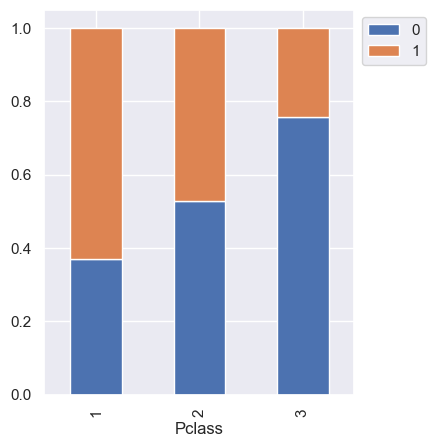

In [91]:
# Plotting output variable against Passenger Class
stacked_barplot(train_data,"Pclass","Survived")

_A higher proportion of passengers from class 1 survived, followed by class 2 and lastly by class 3._

#### Check for correlations amongst variables

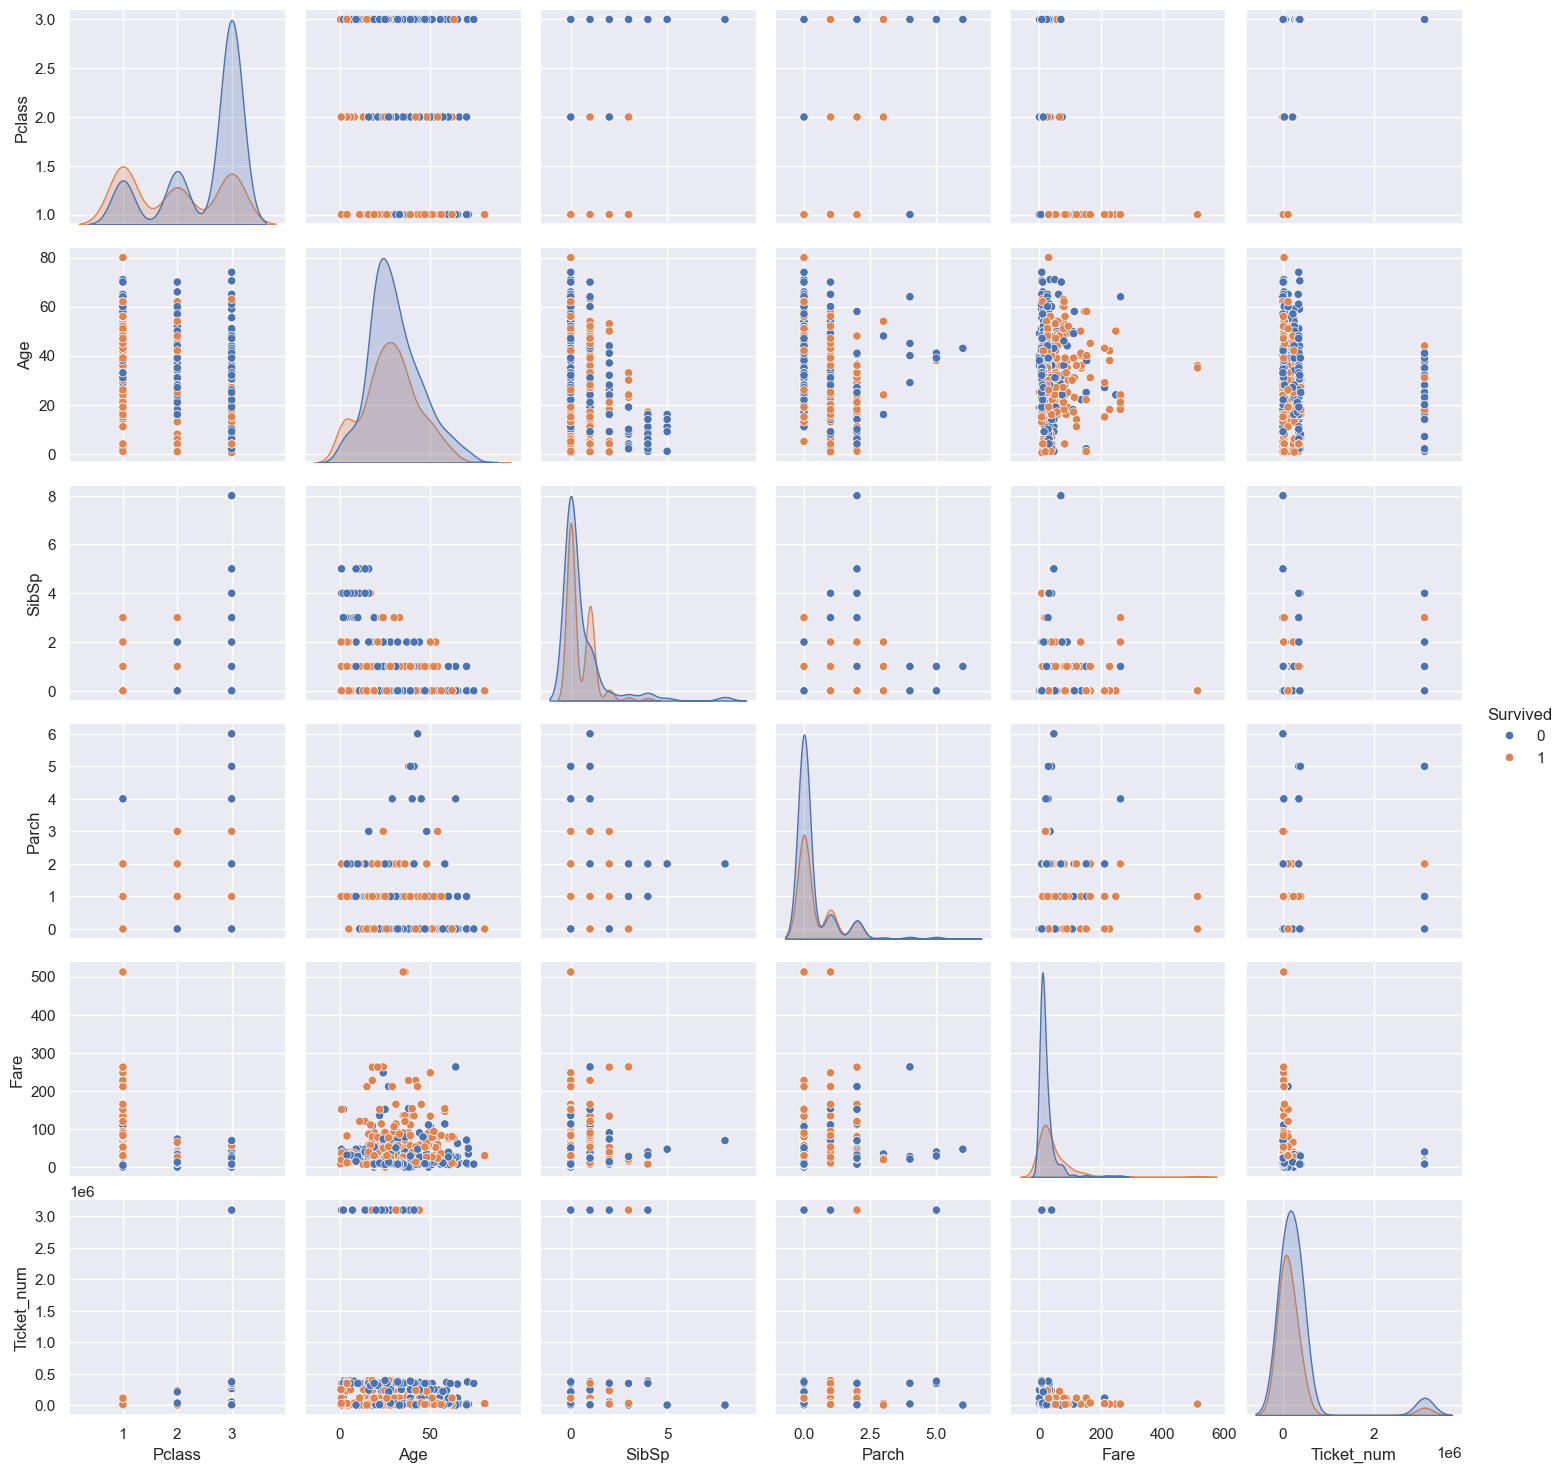

In [97]:
sns.pairplot(train_data,hue="Survived")

- There is some correlation between Passenger class and Fare, and slight correlation between passenger class and the numeric portion of the Ticket.
- There is some correlation between number of siblings and spouses aboard, and passenger age. Older passengers were accompanied by lesser siblings or spouses.
- Higher numeric portion of ticket seems to have lower fare.
- There exist two separate peaks on SibSp distribution for survived passengers and not for the ones who did not survive, indicating that there were higher chances of survival if passengers were accompanied by siblings or spouse.

In [101]:
# Separating target variable and other variables
X = df.drop("Survived",axis=1)
y = df["Survived"]

In [102]:
# Check survival ratio in full training dataset
survival_ratio = sum(1 for val in y if val == 1)/len(y)
print(f"Survival ratio: {survival_ratio:.2%}")

Survival ratio: 38.38%


In [103]:
# Split training data into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state=1,stratify=y)

In [104]:
# Check shape of split data
print("X_train dataset shape:", X_train.shape)
print("y_train array shape:", y_train.shape)
print("X_val dataset shape:", X_val.shape)
print("y_val array dataset shape:", y_val.shape)

X_train dataset shape: (668, 11)
y_train array shape: (668,)
X_val dataset shape: (223, 11)
y_val array dataset shape: (223,)


In [105]:
# Check survival ratio in split data
survival_ratio_train = sum(1 for val in y_train if val == 1)/len(y_train)
survival_ratio_val = sum(1 for val in y_val if val == 1)/len(y_val)
print(f"Survival ratio in training data: {survival_ratio_train:.2%}")
print(f"Survival ratio in validation data: {survival_ratio_val:.2%}")

Survival ratio in training data: 38.32%
Survival ratio in validation data: 38.57%


### Data Preprocessing Pipeline (Column Transformation, One Hot Encoding, Imputation)

* We will drop/modify columns to prepare for new data
* We will perform one hot encoding on categorical variables
* We will use median to impute missing values in Age column.
* We will use most_frequent value to impute missing values in Embarked column.

In [107]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    """
    Custom Column Transformer to drop specified columns
    """
    def __init__(self,columns_to_drop=[]):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self  # No fitting is required for dropping columns

    def transform(self, X):
        return X.drop(columns=self.columns_to_drop,axis=1)

class ColumnSplitter(BaseEstimator, TransformerMixin):
    """
    Custom Column Transformer to split specified column
    Args:
        column: Column to split
        new_columns: Columns after splitting
        drop_columns: Columns to drop after split
        modify_column: column to be modified after split
        modify_function: Function to apply to dataset to modify specific columns after split
    Returns:
        X: Dataset after transformation
    """
    def __init__(self,column,new_columns,drop_columns=None,modify_column=None,modify_function=None):
        self.column = column
        self.new_columns = new_columns
        self.drop_columns = drop_columns
        self.modify_column = modify_column
        self.modify_function = modify_function

    def fit(self,X,y=None):
        return self  # No fitting is required for dropping columns

    def transform(self,X):
        X[self.new_columns] = X[self.column].str.extract(r'(.*?)(\d+)$')
        
        if self.drop_columns:
            X.drop(self.drop_columns,axis=1,inplace=True)
        
        if self.modify_column and self.modify_function:
            X[self.modify_column] = X[self.modify_column].apply(self.modify_function)
        
        return X

In [108]:
# Create preprocessors
column_dropper = ColumnDropper(
    columns_to_drop = ["PassengerId","Name","Cabin"]
)

column_splitter = ColumnSplitter(
    column = "Ticket",
    new_columns = ["Ticket_string","Ticket_num"],
    drop_columns = ["Ticket_string","Ticket"],
    modify_column = "Ticket_num",
    modify_function = lambda x:pd.to_numeric(x, errors="coerce") # Coerce any non-numeric to NaN
)
    

categorical_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("encoder",OneHotEncoder(handle_unknown="ignore"))
])

numerical_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="median")),
    ("scaler",StandardScaler())
    ])

# Combine into ColumnTransformer

col_transformers = ColumnTransformer(
    transformers = [
        ("cat",categorical_transformer,cat_vars),
        ("num",numerical_transformer,num_vars),
    ], remainder='passthrough'
)

preprocessor = Pipeline(steps = [
    ("drop",column_dropper),
    ("split",column_splitter),
    ("transformers",col_transformers)
])

In [109]:
# Fit and transform on the training set, then transform on the validation set
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

### Model Building

#### Evaluation Method
We will print multiple scores, but will compare accuracy for model evaluation.

In [112]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

#### Mulitple Models

In [114]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))

results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Performance:" "\n")

for name, model in models:
    scoring = "accuracy"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_processed, y=y_train, scoring=scoring, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))

print("\n" "Training Performance:" "\n")

for name, model in models:
    model.fit(X_train_processed, y_train)
    scores = accuracy_score(y_train, model.predict(X_train_processed)) * 100
    print("{}: {}".format(name, scores))


Cross-Validation Performance:

Bagging: 82.33531590169454
Random forest: 83.38233643811022
GBM: 81.28829536527886
Adaboost: 79.63752665245202
Xgboost: 80.68679160588037
dtree: 78.14162271350017

Training Performance:

Bagging: 98.05389221556887
Random forest: 99.8502994011976
GBM: 92.21556886227546
Adaboost: 84.88023952095809
Xgboost: 99.55089820359282
dtree: 99.8502994011976


In [125]:
print("\n" "Validation Performance:" "\n")
for name, model in models:
    scores = accuracy_score(y_val, model.predict(X_val_processed)) * 100
    print("{}: {}".format(name, scores))


Validation Performance:

Bagging: 82.51121076233184
Random forest: 82.95964125560538
GBM: 83.40807174887892
Adaboost: 78.47533632286996
Xgboost: 84.30493273542601
dtree: 76.68161434977578


#### Hyperparameter Tuning

* XGBoost, Gradient Boost, and RandomForest are performing fairly well on validation dataset. We will select one bagging-based technique (RandomForest) and one boosting technique (XGBoost), which will be tuned further, to ensure better performance and avoid overfitting.
* Let's start with RandomizedSearchCV to arrive at an approximate hyperparameter space and then use GridSearchCV to find the right parameters for best model performance.

##### Let's tune Random forest using Randomized Search

In [131]:
rf = RandomForestClassifier(random_state=1)

# Define a hyperparameter space
param_dist = {
    'n_estimators': [50, 100, 200, 300, 400, 500],  # Number of trees
    'max_depth': [None, 10, 20, 30, 40, 50],        # Tree depth
    'min_samples_split': [4, 5, 10, 20],            # Minimum samples to split
    'min_samples_leaf': [2, 4, 8],               # Minimum samples at leaf
    'max_features': [0.3, 0.5, 0.7, None],               # Number of features per split
    'bootstrap': [True, False],                     # Bootstrap sampling
    "min_impurity_decrease":[0.001, 0.002, 0.003],
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

# Fit the GridSearchCV
random_search.fit(X_train_processed, y_train)

# Get the best parameters from GridSearchCV
print("Best Parameters from RandomizedSearchCV:", random_search.best_params_)

Best Parameters from RandomizedSearchCV: {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.003, 'max_features': 0.3, 'max_depth': 50, 'bootstrap': True}


##### Let's fine tune Random Forest using GridSearchCV

In [133]:
# Define a hyperparameter grid
params = {
    'n_estimators': [75, 100, 200],           # Number of trees
    'max_depth': [30, 40, 50],                 # Tree depth
    'min_samples_split': [2, 4, 6],            # Minimum samples to split
    'min_samples_leaf': [2, 4, 6],              # Minimum samples at leaf
    'max_features': [0.3, 0.5, 0.7],           # Number of features per split
    "min_impurity_decrease":[0.002, 0.003, 0.004],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=params,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

# Fit the GridSearchCV
grid_search.fit(X_train_processed, y_train)

# Get the best parameters from GridSearchCV
print("Best Parameters from GridSearchCV:", grid_search.best_params_)

Best Parameters from GridSearchCV: {'max_depth': 30, 'max_features': 0.5, 'min_impurity_decrease': 0.002, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 75}


In [135]:
rf_tuned = grid_search.best_estimator_

# Fit the best algorithm to the data.
rf_tuned.fit(X_train_processed, y_train)

RandomForestClassifier(max_depth=30, max_features=0.5,
                       min_impurity_decrease=0.002, min_samples_leaf=2,
                       min_samples_split=6, n_estimators=75, random_state=1)

In [139]:
# Check model performance of tuned RandomForest Model on training data
model_performance_classification_sklearn(rf_tuned,X_train_processed,y_train)

,Accuracy,Recall,Precision,F1
0,0.896707,0.789062,0.930876,0.854123


In [141]:
# Check model performance of tuned RandomForest Model on validation data
model_performance_classification_sklearn(rf_tuned,X_val_processed,y_val)

,Accuracy,Recall,Precision,F1
0,0.838565,0.697674,0.857143,0.769231


- We see some gap between training and validation set performance with these parameters.
- Let's update some of those to reduce overfitting.

In [191]:
# Update parameters to reduce overfitting
rf_tuned_2 = RandomForestClassifier(
    max_features=0.7,
    min_samples_leaf=6,
    n_estimators=75,
    random_state=1,
    max_depth=5,
    min_samples_split=12,
    min_impurity_decrease=0.002,
)

# Fit the best algorithm to the data.
rf_tuned_2.fit(X_train_processed, y_train)

RandomForestClassifier(max_depth=5, max_features=0.7,
                       min_impurity_decrease=0.002, min_samples_leaf=6,
                       min_samples_split=12, n_estimators=75, random_state=1)

In [193]:
# Check model performance of tuned RandomForest Model on training data
model_performance_classification_sklearn(rf_tuned_2,X_train_processed,y_train)

,Accuracy,Recall,Precision,F1
0,0.872754,0.742188,0.909091,0.817204


In [195]:
# Check model performance of tuned RandomForest Model on validation data
model_performance_classification_sklearn(rf_tuned_2,X_val_processed,y_val)

,Accuracy,Recall,Precision,F1
0,0.838565,0.709302,0.847222,0.772152


_RandomForest Model looks more generalized after fine-tuning to reduce overfitting_

##### Let's tune XGBoost using Randomized Search

In [197]:
# defining model
xgb = XGBClassifier(random_state=1, eval_metric="logloss")

# Parameter grid to pass in RandomSearchCV
param_dist = {
    "n_estimators": [50, 100, 150, 200, 250, 300],
    "scale_pos_weight": [0, 1, 2, 3],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "gamma": [0, 3, 5],
    "subsample": [0.5, 0.7, 0.9, 1.0],
    "colsample_bytree":[0.5,0.7,0.9,1],
    "colsample_bylevel":[0.5,0.7,0.9,1],
}

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,
    n_jobs=-1,
    scoring="accuracy",
    cv=5,
    random_state=1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_processed, y_train)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 1, 'n_estimators': 200, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1, 'colsample_bylevel': 0.5} with CV score=0.8338345864661655:


##### Let's fine tune XGBoost using GridSearchCV

In [200]:
# Define a hyperparameter grid
params = {
    "n_estimators": [150, 200, 250],
    "scale_pos_weight": [0, 1, 2],
    "learning_rate": [0.02, 0.05, 0.1],
    "gamma": [0, 0.5, 1],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bylevel":[0.5,0.7],
}

# Initialize GridSearchCV
grid_obj = GridSearchCV(
    estimator=xgb,
    param_grid=params,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

# Fit the GridSearchCV
grid_obj.fit(X_train_processed, y_train)

# Get the best parameters from GridSearchCV
print("Best Parameters from GridSearchCV:", grid_obj.best_params_)

Best Parameters from GridSearchCV: {'colsample_bylevel': 0.5, 'gamma': 1, 'learning_rate': 0.05, 'n_estimators': 150, 'scale_pos_weight': 1, 'subsample': 1.0}


In [202]:
# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(X_train_processed, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.5, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

In [208]:
# Check model performance of tuned XGBoost Model on training data
model_performance_classification_sklearn(xgb_tuned,X_train_processed,y_train)

,Accuracy,Recall,Precision,F1
0,0.899701,0.796875,0.931507,0.858947


In [210]:
# Check model performance of tuned XGBoost Model on validation data
model_performance_classification_sklearn(xgb_tuned,X_val_processed,y_val)

,Accuracy,Recall,Precision,F1
0,0.843049,0.72093,0.849315,0.779874


- We still see some gap between training and validation set performance with these parameters.
- Let's add regularization and reduce learning rate to reduce overfitting.

In [305]:
# Update parameters to reduce overfitting
xgb_tuned_2 = XGBClassifier(
    random_state = 1,
    n_estimators = 150,
    scale_pos_weight = 1,
    learning_rate = 0.03,
    gamma = 2,
    subsample = 0.9,
    colsample_bylevel = 0.5,
    reg_lambda = 2,
)

# Fit the best algorithm to the data.
xgb_tuned_2.fit(X_train_processed, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.5, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

In [307]:
# Check model performance of tuned XGBoost Model on training data
model_performance_classification_sklearn(xgb_tuned_2,X_train_processed,y_train)

,Accuracy,Recall,Precision,F1
0,0.878743,0.757812,0.910798,0.827292


In [309]:
# Check model performance of tuned XGBoost Model on validation data
model_performance_classification_sklearn(xgb_tuned_2,X_val_processed,y_val)

,Accuracy,Recall,Precision,F1
0,0.838565,0.709302,0.847222,0.772152


##### Let's attach feature names to the original dataframe

In [311]:
# Start with the initial columns after the column_dropper
remaining_columns = X_train.drop(columns=["PassengerId", "Name", "Cabin"]).columns.tolist()

# Handle column_splitter transformation
# Add new columns and remove dropped ones
remaining_columns.remove("Ticket")  # Drop 'Ticket'
remaining_columns.append("Ticket_num")  # Add 'Ticket_num'

# Process categorical and numerical feature names

# Fetch feature names from ColumnTransformer
categorical_features = preprocessor.named_steps['transformers'].named_transformers_['cat'][
    'encoder'
].get_feature_names_out(cat_vars)  # Encoded feature names

numerical_features = num_vars  # Numerical features remain unchanged after scaling

# Combine categorical and numerical features with passthrough columns
passthrough_features = [
    col for col in remaining_columns if col not in cat_vars + num_vars
]
final_feature_names = list(categorical_features) + numerical_features + passthrough_features

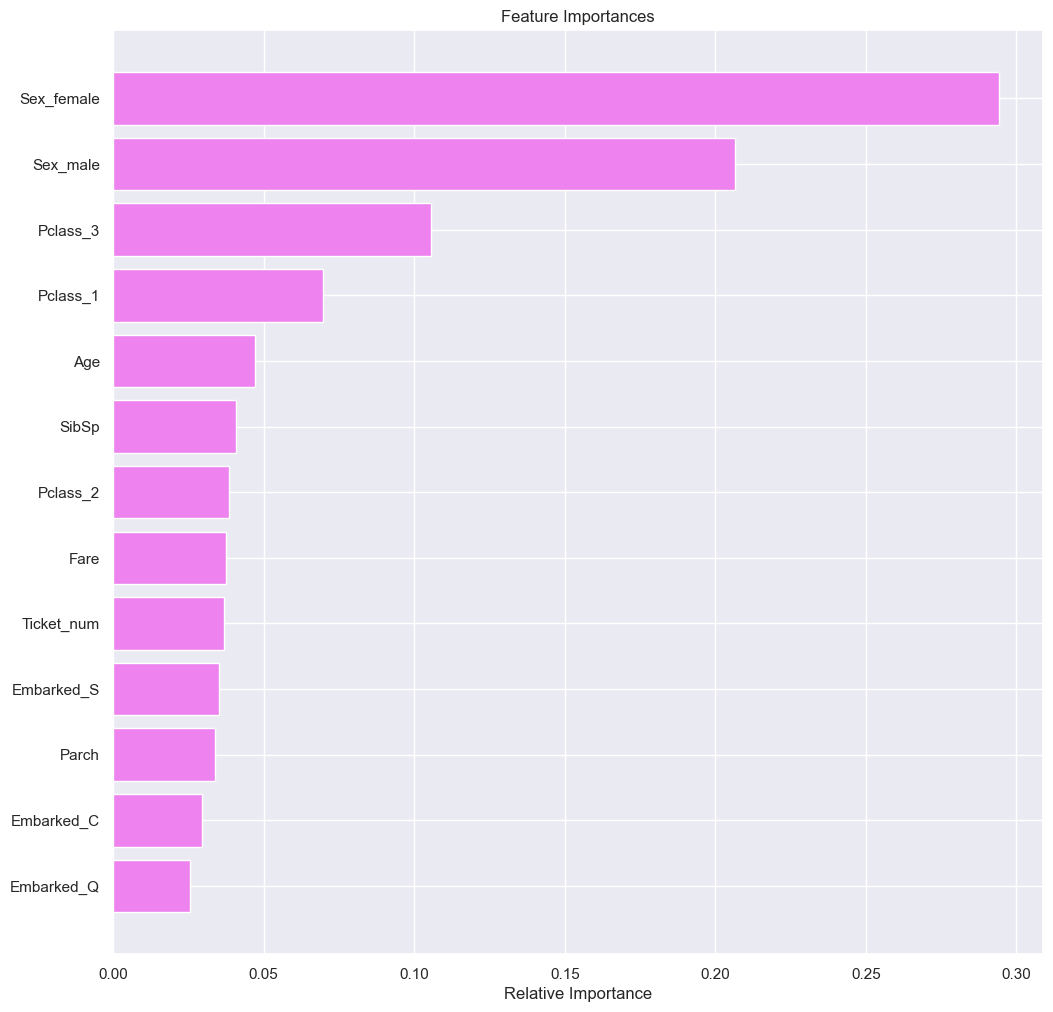

In [313]:
importances = xgb_tuned_2.feature_importances_
indices = np.argsort(importances)
feature_names = list(final_feature_names)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Insights

- Tuned XGBoost has the best performance amongst the two tuned models.
- Passenger Sex, class and age are three most important features


## Test Data Prediction

In [315]:
test_data = pd.read_csv("test.csv")

In [317]:
X_test_preprocessed = preprocessor.transform(test_data)

In [319]:
predictions = xgb_tuned.predict(X_test_preprocessed)

In [321]:
test_df = pd.DataFrame(test_data["PassengerId"])
test_df["Survived"] = predictions

In [323]:
test_df.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
